# Packaged Food Classification Model Using

This notebook contains step by step phase of performing transfer learning on some of pre-trained models that are available and has been trained on larget dataset on a custom dataset specifically, on packaged food dataset that has been created by the Gloo Team.

## 0. Preparing work environment

Let's start by installing the necessary packages

In [ ]:
!pip install tensorflow
!pip install pathlib

Importing the libraries

In [ ]:
import tensorflow as tf
import pathlib
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Fri Dec  6 03:26:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Utilities

In [ ]:
from timeit import default_timer as timer

def count_inference_time(inference_fn=None, *args, **kwargs):
    start = timer()
    inference_fn(*args, **kwargs)
    end = timer()
    return end - start

## 1. Data Preparation

Importing the dataset from roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=API-KEY)
project = rf.workspace("faiqal").project("packaged-food-classification")
version = project.version(9)
dataset = version.download("folder")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Packaged-food-classification-9 in folder:: 100%|██████████| 1066/1066 [00:00<00:00, 9511.72it/s]


Let's see how many data that are available on train, val, and test dir

In [ ]:
# Creating class_names
classes = {
    0: 'Better',
    1: 'LeMinerale',
    2: 'Oreo',
    3: 'PocariSweat',
    4: 'YouC1000'
}

In [ ]:
import os
import pathlib

data_dir = pathlib.Path('/content/Packaged-food-classification-9')

train_dir = pathlib.Path(os.path.join(data_dir, 'train'))
val_dir = pathlib.Path(os.path.join(data_dir, 'valid'))
test_dir = pathlib.Path(os.path.join(data_dir, 'test'))


total_image = 0

for product in classes.values():
  %cd {train_dir/product}
  print(f"Total {product} images in train dir is : {len(os.listdir())}\n")
  total_image += len(os.listdir())

print(f"Total images in train dir is : {total_image}")

/content/Packaged-food-classification-9/train/Better
Total Better images in train dir is : 117

/content/Packaged-food-classification-9/train/LeMinerale
Total LeMinerale images in train dir is : 146

/content/Packaged-food-classification-9/train/Oreo
Total Oreo images in train dir is : 155

/content/Packaged-food-classification-9/train/PocariSweat
Total PocariSweat images in train dir is : 137

/content/Packaged-food-classification-9/train/YouC1000
Total YouC1000 images in train dir is : 176

Total images in train dir is : 731


Let's visualize some of the images

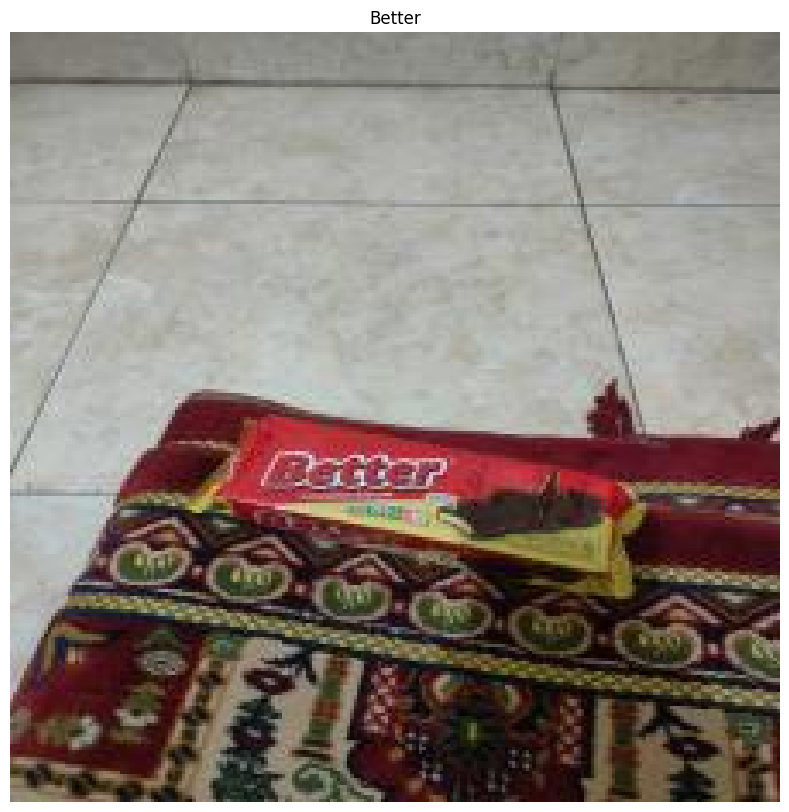

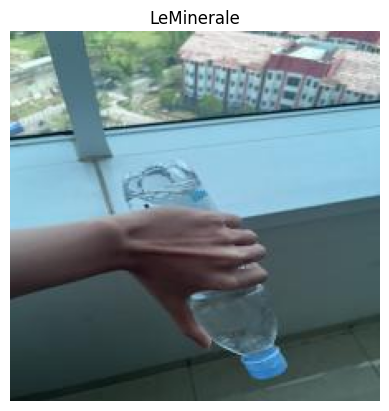

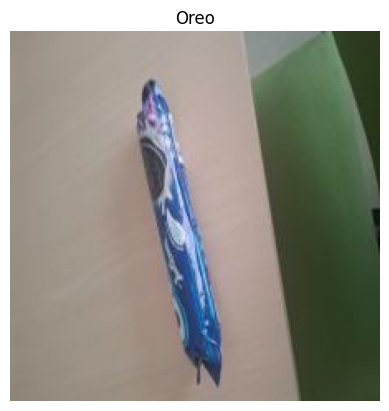

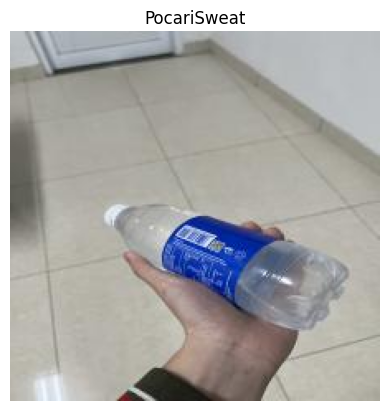

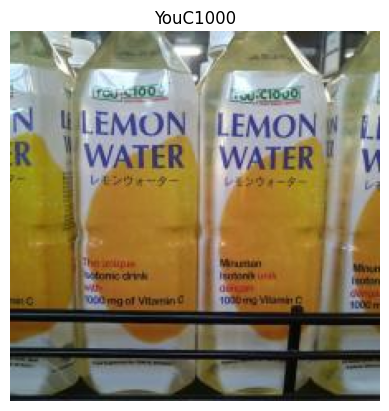

In [ ]:
product_folders = []

for product in classes.values():
  product_folders.append(os.path.join(train_dir, product))

plt.figure(figsize=(15, 10))

for product_folder in product_folders:
  for img_path in os.listdir(product_folder):
    img = plt.imread(os.path.join(product_folder, img_path))
    plt.imshow(img)
    plt.title(product_folder.split('/')[-1])
    plt.axis('off')
    plt.show()
    break

Now that we know what our data looks like, it's time to create tensorflow dataset using `tfds`

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

Found 731 files belonging to 5 classes.
Found 158 files belonging to 5 classes.
Found 157 files belonging to 5 classes.


Create a normalization function

In [ ]:
def normalize(image, label):
    image = image / 255.0  # Scale pixel values to [0, 1]
    return image, label

# Apply normalization to train, validation, and test datasets
train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

# Configure the datasets for performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Let's inspect our dataset

In [ ]:
for images, labels in train_ds.take(1):
  print(f"Images shape : {images.shape}")
  print(f"Labels shape : {labels.shape}")

  # Check max pixel value
  print(f"Max pixel value : {np.max(images)}")

Images shape : (32, 224, 224, 3)
Labels shape : (32, 5)
Max pixel value : 1.0


Let's apply data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## 2. Loading model and weight

Start by loading the model from `tensorflow.keras.applications`

In [ ]:
from tensorflow.keras.applications import MobileNetV2

feature_extractor = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

feature_extractor.trainable = False

feature_extractor.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

We'll make the feature extractor's parameters non-trainable because they already learned highly generalizable features fromt the ImageNet dataset

## 3. Creating custom layers

Let's add our custom layers that takes input in the shape of our feature extractor's output.

We'll be using the tensorflow sequential API

In [ ]:
def build_model(feature_extractor, num_classes=len(classes)):
    inputs = tf.keras.layers.Input(shape=feature_extractor.input_shape[1:])
    x = feature_extractor(inputs, training=feature_extractor.trainable)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = build_model(feature_extractor)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Complite the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Tune the learning rate

In [ ]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=3, activation='softmax')
])

model_tune.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 432)           │         583,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 21168)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │         338,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 922,027 (3.52 MB)

 Trainable params: 338,867 (1.29 MB)

 Non-trainable params: 583,160 (2.22 MB)

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [ ]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.8)

# Set the training parameters
model_tune.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

In [ ]:
# Train the model
# history = model_tune.fit(train_ds, epochs=50, callbacks=[lr_schedule])

Epoch 1/50


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 3), output.shape=(None, 3)

(1e-08, 0.001, 0.0, 2.0)

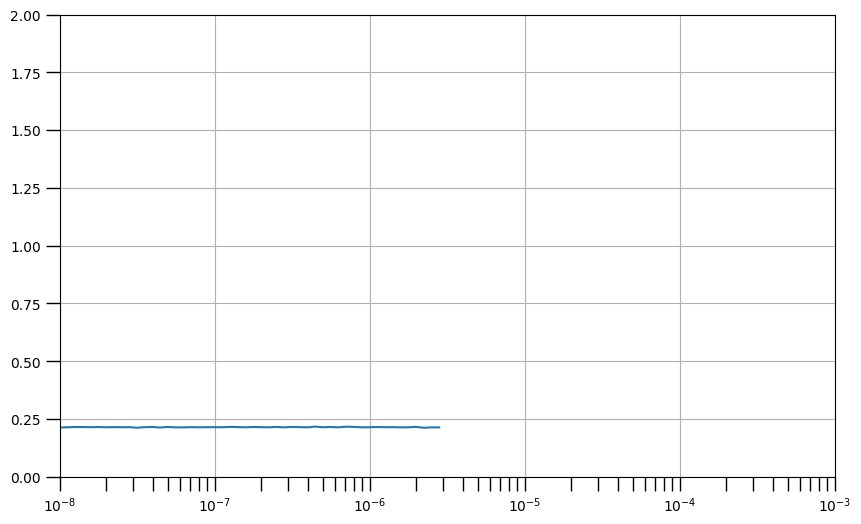

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(50) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 2])

## 4. Training the model

Let's start the training

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=2
)

Epoch 1/15
23/23 - 36s - 2s/step - accuracy: 0.6005 - loss: 1.0173 - val_accuracy: 0.8418 - val_loss: 0.3418
Epoch 2/15
23/23 - 17s - 726ms/step - accuracy: 0.8892 - loss: 0.3220 - val_accuracy: 0.9557 - val_loss: 0.2146
Epoch 3/15
23/23 - 8s - 364ms/step - accuracy: 0.9371 - loss: 0.2076 - val_accuracy: 0.9367 - val_loss: 0.1891
Epoch 4/15
23/23 - 8s - 366ms/step - accuracy: 0.9466 - loss: 0.1597 - val_accuracy: 0.9557 - val_loss: 0.1786
Epoch 5/15
23/23 - 10s - 431ms/step - accuracy: 0.9562 - loss: 0.1335 - val_accuracy: 0.9620 - val_loss: 0.1379
Epoch 6/15
23/23 - 8s - 363ms/step - accuracy: 0.9754 - loss: 0.0961 - val_accuracy: 0.9620 - val_loss: 0.1163
Epoch 7/15
23/23 - 9s - 372ms/step - accuracy: 0.9685 - loss: 0.0850 - val_accuracy: 0.9684 - val_loss: 0.1145
Epoch 8/15
23/23 - 8s - 333ms/step - accuracy: 0.9713 - loss: 0.0912 - val_accuracy: 0.9747 - val_loss: 0.1064
Epoch 9/15
23/23 - 8s - 367ms/step - accuracy: 0.9699 - loss: 0.1127 - val_accuracy: 0.9367 - val_loss: 0.1783
E

## 5. Evaluating the model

Let's visualize the training processss

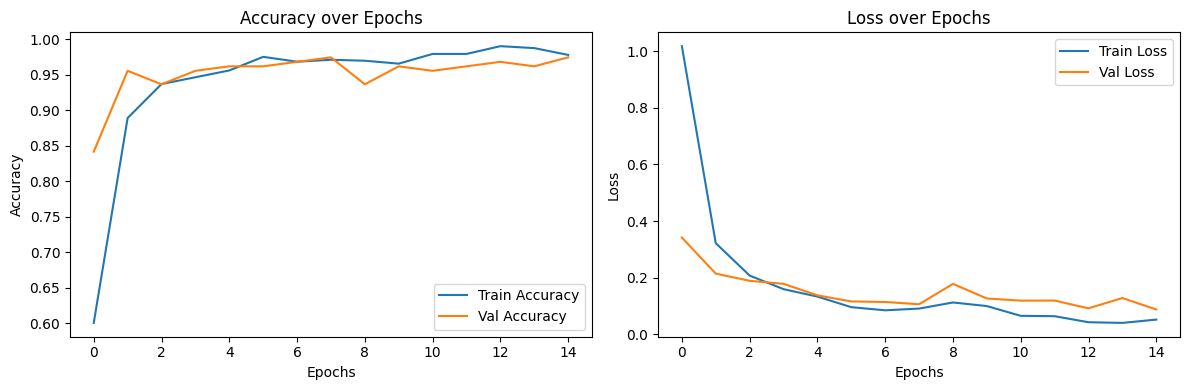

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Evaluzating on test dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


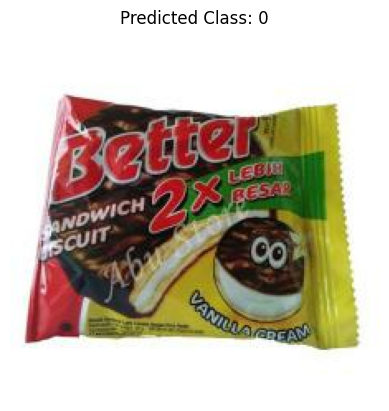

Predicted Probabilities: [9.9990833e-01 1.0961371e-05 2.8924860e-06 2.3685368e-07 7.7550983e-05]
True Label: [1. 0. 0. 0. 0.]


In [ ]:
# Run inference on test_ds
for images, labels in test_ds.take(1):
    predictions = model.predict(images)


    # Displaying the first image in the batch and its predicted class
    plt.imshow(images[17].numpy())  # Display the first image
    plt.title(f"Predicted Class: {predictions[17].argmax()}")
    plt.axis('off')
    plt.show()

    # Print predicted probabilities and true label
    print("Predicted Probabilities:", predictions[17])
    print("True Label:", labels[17].numpy())


In [ ]:
# Accuracy on test set

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 945ms/step - accuracy: 0.9729 - loss: 0.0750
Test Loss: 0.09098976105451584
Test Accuracy: 0.9617834687232971


In [ ]:
!pip install pillow

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


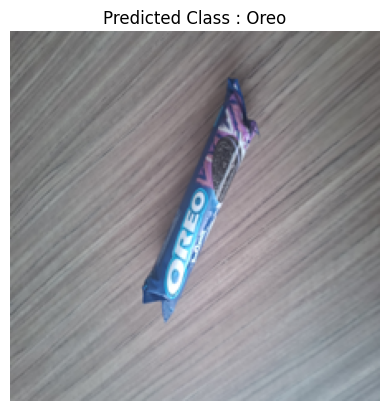

predictions confidence : [[3.1448049e-05 1.1611003e-05 9.9995661e-01 1.3534256e-07 1.9565439e-07]]


In [ ]:
from PIL import Image
import numpy as np

def inference_pipeline(img_path):
  img = Image.open(img_path)
  img = img.resize((224, 224))
  img_array = np.array(img)
  img_array = img_array / 255.0
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array.astype('float32')

  return img, img_array

img, img_array = inference_pipeline('/content/20241122_124559.jpg')

predictions = model.predict(img_array)

prediction_index = np.argmax(predictions)
predicted_class = classes[prediction_index]

plt.imshow(img)

plt.title(f'Predicted Class : {predicted_class}')
plt.axis('off')
plt.show()

print(f"predictions confidence : {predictions}")

In [ ]:
type(model)

keras.src.models.functional.Functional

## 6. Exporting the model

In [ ]:
%cd /content

/content


In [ ]:
!mkdir saved_model

Let's now export the model and save it into the created dir

In [ ]:
## Save into saved model format

In [ ]:
model.export('/content/saved_model')

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134177548064496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177548251232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177548249296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177548250000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177548251760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177548249648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177258016784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177258017312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177258013440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177258016960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134177

In [ ]:
!zip -r modelv4.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/saved_model.pb (deflated 91%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 78%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)


save into h5

In [ ]:
model.save('modelv3.h5')

In [ ]:
# Path to the saved model directory
saved_model_dir = '/content/saved_model'

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the TFLite model to a .tflite file
tflite_model_path = 'modelv4.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model has been converted and saved as {tflite_model_path}")

Model has been converted and saved as modelv4.tflite


## 7. Inference with TFLite model format

In [ ]:
import numpy as np
import tensorflow.lite as tflite

interpreter = tflite.Interpreter(model_path='modelv4.tflite')
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print the input and output details (for debugging)
print("Input Details:", input_details)
print("Output Details:", output_details)

Input Details: [{'name': 'serving_default_keras_tensor_158:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 180, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([-1,  5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


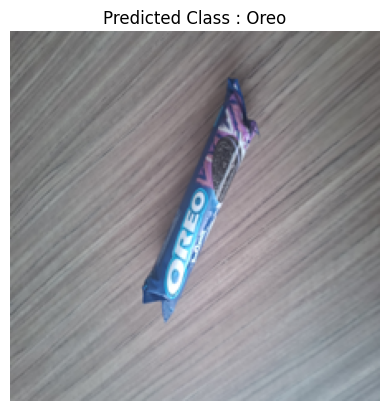

predictions confidence : [[3.14481076e-05 1.16110705e-05 9.99956608e-01 1.35343058e-07
  1.95653627e-07]]


In [ ]:
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']

img, img_array = inference_pipeline('/content/20241122_124559.jpg')

interpreter.set_tensor(input_details[0]['index'], img_array)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

plt.imshow(img)

plt.title(f'Predicted Class : {classes[output_data.argmax()]}')
plt.axis('off')
plt.show()

print(f"predictions confidence : {output_data}")

## 8. Converting into tfjs model

Let's convert the saved model format to be able to work in tfjs

In [ ]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 53.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uni

In [ ]:
!mkdir tfjs_modelv4

In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs

# Convert the model into tfjs format
tfjs.converters.convert_tf_saved_model(
    saved_model_dir='/content/saved_model',
    output_dir='/content/tfjs_modelv4'
)

In [ ]:
!zip -r tfjs_modelv4.zip tfjs_modelv4

  adding: tfjs_modelv4/ (stored 0%)
  adding: tfjs_modelv4/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_modelv4/model.json (deflated 96%)
  adding: tfjs_modelv4/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_modelv4/group1-shard3of3.bin (deflated 7%)
